In [ ]:
!pip install torch-geometric

In [ ]:
!pip install networkx matplotlib

In [ ]:
!pip install networkx torch scikit-learn

# IMPORTING LIBRARIES

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


# LOADING CORA WITH PAPER TITLES

In [5]:
!wget https://people.cs.umass.edu/~mccallum/data/cora.tar.gz

--2023-12-13 13:59:29--  https://people.cs.umass.edu/~mccallum/data/cora.tar.gz
Resolving people.cs.umass.edu (people.cs.umass.edu)... 128.119.240.99
Connecting to people.cs.umass.edu (people.cs.umass.edu)|128.119.240.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264768650 (253M) [application/x-gzip]
Saving to: ‘cora.tar.gz’

cora.tar.gz         100%[===================>] 252.50M  44.3MB/s    in 6.2s    

2023-12-13 13:59:36 (41.0 MB/s) - ‘cora.tar.gz’ saved [264768650/264768650]



# Extracting contents of dataset

In [ ]:
!tar -zxvf cora.tar.gz


# Load cora.content File into a DataFrame

In [7]:
df = pd.read_csv('/content/cora/papers', sep='\t', header=None, names=['paper_id', 'word_attributes', 'class_label'])


#  Load Cora Dataset using PyTorch Geometric

In [ ]:
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
aligned_titles = df["class_label"].tolist()
aligned_indices = df["paper_id"].tolist()



# Define a Simple Graph Convolutional Network (GCN) Model

In [9]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the Model, Loss Function, and Optimizer

In [10]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


# Training and Testing FunctionsNew Section

In [11]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = accuracy_score(data.y[data.test_mask].numpy(), pred[data.test_mask].numpy())
    return acc


# Training Loop

In [12]:
num_epochs = 200
for epoch in range(1, num_epochs + 1):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')


Epoch: 1, Loss: 1.9589, Test Accuracy: 0.4340
Epoch: 2, Loss: 1.8543, Test Accuracy: 0.5950
Epoch: 3, Loss: 1.7209, Test Accuracy: 0.6210
Epoch: 4, Loss: 1.5539, Test Accuracy: 0.6120
Epoch: 5, Loss: 1.3960, Test Accuracy: 0.6290
Epoch: 6, Loss: 1.2453, Test Accuracy: 0.6830
Epoch: 7, Loss: 1.0968, Test Accuracy: 0.7310
Epoch: 8, Loss: 0.9563, Test Accuracy: 0.7620
Epoch: 9, Loss: 0.8273, Test Accuracy: 0.7730
Epoch: 10, Loss: 0.7113, Test Accuracy: 0.7790
Epoch: 11, Loss: 0.6076, Test Accuracy: 0.7830
Epoch: 12, Loss: 0.5161, Test Accuracy: 0.7840
Epoch: 13, Loss: 0.4361, Test Accuracy: 0.7890
Epoch: 14, Loss: 0.3674, Test Accuracy: 0.7920
Epoch: 15, Loss: 0.3091, Test Accuracy: 0.7890
Epoch: 16, Loss: 0.2604, Test Accuracy: 0.7860
Epoch: 17, Loss: 0.2195, Test Accuracy: 0.7860
Epoch: 18, Loss: 0.1852, Test Accuracy: 0.7840
Epoch: 19, Loss: 0.1562, Test Accuracy: 0.7830
Epoch: 20, Loss: 0.1320, Test Accuracy: 0.7830
Epoch: 21, Loss: 0.1118, Test Accuracy: 0.7790
Epoch: 22, Loss: 0.095

In [34]:

# Final Evaluation
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
acc = accuracy_score(data.y[data.test_mask].numpy(), pred[data.test_mask].numpy())
num_features = out.shape[1]  # Number of output features

# Print final evaluation details
print(f'Final Evaluation - Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Num Features: {num_features}')


Final Evaluation - Loss: 0.0076, Test Accuracy: 0.8050, Num Features: 7


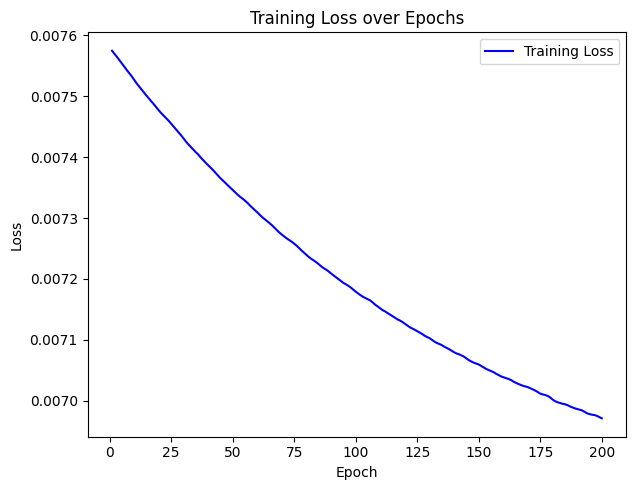

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



plt.tight_layout()
plt.show()


#  Visualize the Graph

<ipython-input-23-2033551eec52>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap("Set1", len(unique_classes))


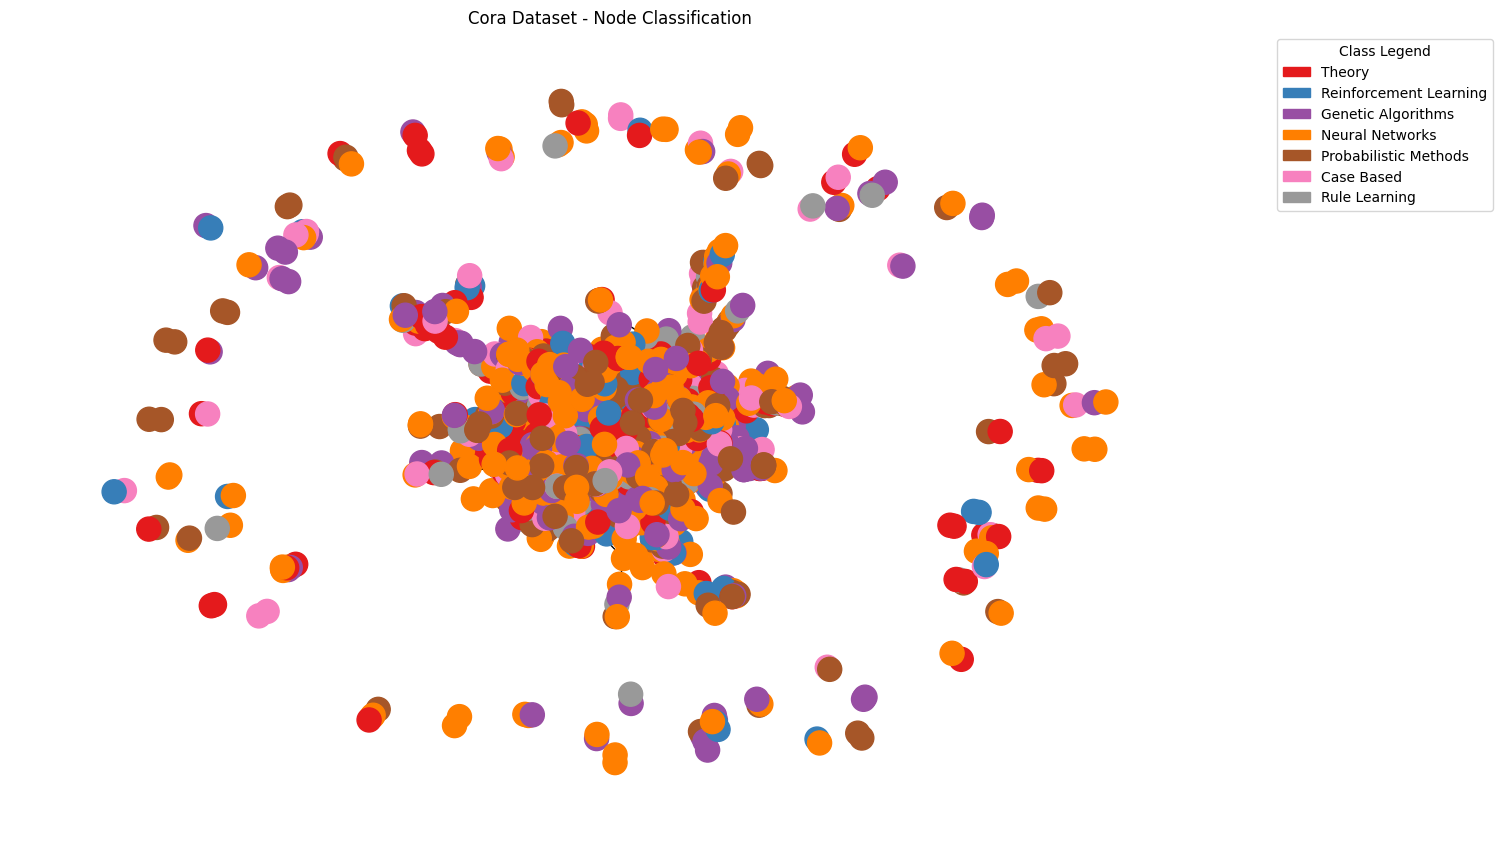

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_graph(data):
    G = nx.Graph()
    edge_index = data.edge_index.cpu().numpy()
    for i in range(edge_index.shape[1]):
        src, tgt = edge_index[0, i], edge_index[1, i]
        G.add_edge(src, tgt)

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))

    # Draw the graph
    nx.draw(G, pos, with_labels=False, node_color=data.y.cpu().numpy(), cmap="Set1")

    # Create a color legend
    unique_classes = sorted(set(data.y.cpu().numpy()))
    class_names = {
        0: 'Theory',
        1: 'Reinforcement Learning',
        2: 'Genetic Algorithms',
        3: 'Neural Networks',
        4: 'Probabilistic Methods',
        5: 'Case Based',
        6: 'Rule Learning'
    }

    color_map = plt.cm.get_cmap("Set1", len(unique_classes))

    handles = []
    for i, class_label in enumerate(unique_classes):
        class_name = class_names[class_label]
        patch = mpatches.Patch(color=color_map(i), label=class_name)
        handles.append(patch)

    plt.legend(handles=handles, title="Class Legend", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title("Cora Dataset - Node Classification")
    plt.show()

# Step 10: Visualize the graph
visualize_graph(data)


# Display Paper Titles Under Various Categories After Classification

In [14]:
model.eval()
out = model(data.x, data.edge_index)
predicted_labels = out.argmax(dim=1)
category_titles = {category: [] for category in range(dataset.num_classes)}

for idx, label in enumerate(predicted_labels):
    # Find the original index in the dataframe based on PyG's node indices
    mask_indices = (data.test_mask.nonzero().view(-1) == idx).nonzero()

    # Check if the index is found and within the bounds of the aligned_titles list
    if mask_indices.numel() > 0:
        original_idx = mask_indices.item()
        if original_idx < len(aligned_titles):
            category_titles[label.item()].append(aligned_titles[original_idx])



In [ ]:
!pip install ipywidgets


In [30]:
import re
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Assuming you have a class_labels_to_names dictionary that maps class labels to category names
class_labels_to_names = {
    0: 'Theory',
    1: 'Reinforcement_Learning',
    2: 'Genetic_Algorithms',
    3: 'Neural_Networks',
    4: 'Probabilistic_Methods',
    5: 'Case_Based',
    6: 'Rule_Learning'
}

# Assuming data, model, and aligned_titles are defined elsewhere in your code

# Set the model to evaluation mode
model.eval()

# Forward pass to get predictions
out = model(data.x, data.edge_index)

# Get predicted labels
predicted_labels = out.argmax(dim=1)

# Replace class labels with category names
predicted_category_names = [class_labels_to_names[label.item()] for label in predicted_labels]

# Create a dictionary to store lists of titles for each category
category_titles = {category_name: [] for category_name in class_labels_to_names.values()}


# Loop through predicted category names and aligned titles
for idx, category_name in enumerate(predicted_category_names):
    # Find the original index in the dataframe based on PyG's node indices
    mask_indices = (data.test_mask.nonzero().view(-1) == idx).nonzero()

    # Check if the index is found and within the bounds of the aligned_titles list
    if mask_indices.numel() > 0:
        original_idx = mask_indices.item()
        if original_idx < len(aligned_titles):
            # Remove words within < > and </ > tags using regular expressions
            cleaned_title = re.sub(r'<[^>]*>', '', aligned_titles[original_idx])

            # Append the cleaned title to the corresponding category's list
            category_titles[category_name].append(cleaned_title)

# Create separate DataFrames for each category
category_dataframes = {}
for category_name, paper_titles in category_titles.items():
    df_category = pd.DataFrame({'Paper Titles': paper_titles})
    category_dataframes[category_name] = df_category

# Create a dropdown widget with category names
category_dropdown = widgets.Dropdown(options=['__Choose Here__'] + list(category_dataframes.keys()), description='Domain')

# Create an output widget to display the selected category's table
output_widget = widgets.Output()

# Display the widgets
display(widgets.VBox([category_dropdown, output_widget]))

# Create a function to update the output based on the selected category
def update_output(change):
    selected_category = change.new

    if selected_category == '__Choose Here__':
        with output_widget:
            output_widget.clear_output(wait=True)
            print("Please choose a category.")
    else:
        df_category = category_dataframes[selected_category]
        num_papers = len(df_category)

        with output_widget:
            output_widget.clear_output(wait=True)
            print(f"\nPAPERS ON {selected_category} ({num_papers} papers):\n")

            # Center-align the paper titles
            df_category_styled = df_category.style.set_table_styles([
                {'selector': 'th', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
                {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center')]}
            ])
            display(df_category_styled)

# Connect the dropdown to the update function
category_dropdown.observe(update_output, names='value')


# Search box and Display Papers Based on the Search Keyword

In [32]:
import re
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Assuming you have a class_labels_to_names dictionary that maps class labels to category names
class_labels_to_names = {
    0: 'Theory',
    1: 'Reinforcement_Learning',
    2: 'Genetic_Algorithms',
    3: 'Neural_Networks',
    4: 'Probabilistic_Methods',
    5: 'Case_Based',
    6: 'Rule_Learning'
}

# Assuming data, model, and aligned_titles are defined elsewhere in your code

# Set the model to evaluation mode
model.eval()

# Forward pass to get predictions
out = model(data.x, data.edge_index)

# Get predicted labels
predicted_labels = out.argmax(dim=1)

# Replace class labels with category names
predicted_category_names = [class_labels_to_names[label.item()] for label in predicted_labels]

# Create a dictionary to store lists of titles for each category
category_titles = {category_name: [] for category_name in class_labels_to_names.values()}
category_titles['Miscellaneous'] = []

# Loop through predicted category names and aligned titles
for idx, category_name in enumerate(predicted_category_names):
    # Find the original index in the dataframe based on PyG's node indices
    mask_indices = (data.test_mask.nonzero().view(-1) == idx).nonzero()

    # Check if the index is found and within the bounds of the aligned_titles list
    if mask_indices.numel() > 0:
        original_idx = mask_indices.item()
        if original_idx < len(aligned_titles):
            # Remove words within < > and </ > tags using regular expressions
            cleaned_title = re.sub(r'<[^>]*>', '', aligned_titles[original_idx])

            # Append the cleaned title to the corresponding category's list
            category_titles[category_name].append(cleaned_title)

# Create a combined DataFrame for all categories
all_papers_df = pd.concat([pd.DataFrame({'Category': [category_name]*len(paper_titles), 'Paper Title': paper_titles})
                           for category_name, paper_titles in category_titles.items()], ignore_index=True)

# Create a search box for entering keywords
keyword_search = widgets.Text(placeholder='Enter keyword', description='Keyword:')

# Create an output widget to display the search results
output_widget = widgets.Output()

# Display the widgets
display(widgets.VBox([keyword_search, output_widget]))

# Create a function to update the output based on the entered keyword
def update_output(change):
    keyword = keyword_search.value.lower()  # Convert keyword to lowercase for case-insensitive search

    with output_widget:
        output_widget.clear_output(wait=True)

        # Filter papers based on the keyword
        if keyword:
            matching_papers = all_papers_df[all_papers_df['Paper Title'].str.lower().str.contains(keyword)]
            num_papers = len(matching_papers)

            print(f"\nSearch Results for '{keyword}' ({num_papers} papers):\n")

            # Center-align the paper titles
            matching_papers_styled = matching_papers.style.set_table_styles([
                {'selector': 'th', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
                {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center')]}
            ])
            display(matching_papers_styled)

# Connect the search box to the update function
keyword_search.observe(update_output, names='value')
